In [26]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

2023-03-04 01:16:10.949660: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [27]:
##GPU 사용 시
device = torch.device("cuda:1")
bertmodel, vocab = get_pytorch_kobert_model()

using cached model. /home/mglee/VSCODE/git_folder/comments_sentiment_label/code/.cache/kobert_v1.zip
using cached model. /home/mglee/VSCODE/git_folder/comments_sentiment_label/code/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


# 예측할 데이터 셋 준비

In [125]:
import pandas as pd
data = pd.read_csv("/home/mglee/VSCODE/git_folder/KakaoPay_ESG/data/news_comments_date.csv")

In [126]:
data['sentiment'] = [0] * 411989

In [127]:
data

,Unnamed: 0,url,text,ymd,sentiment
0,0,https://n.news.naver.com/mnews/article/comment...,네이버 페이보다 수수료 낮을까?,2017-01-19,0
1,1,https://n.news.naver.com/mnews/article/comment...,공부해야할 과목이 또 하나 늘었군.. - IT종사자 -,2017-01-19,0
2,2,https://n.news.naver.com/mnews/article/comment...,"네이버도 정기결제, 포인트 적립 다 똑같이 되고 먼저 됐는데요.",2017-01-25,0
3,3,https://n.news.naver.com/mnews/article/comment...,"네이버페이 좋아요.네이버페이체크카드로 교통카드 사용하면 포인트주고, 천원써도 포인...",2017-01-22,0
4,4,https://n.news.naver.com/mnews/article/comment...,네이버페이는 편할거라 생각해서 썼는데 포인트도 제한 교통적립 되긴되는건가?카카오페이...,2017-01-22,0
...,...,...,...,...,...
411984,71387,https://v.daum.net/v/20221226050109898,네이버가 짱이지 ㅋㅋ\n\n올개 30만원 모임\n\n얌얌,2022-12-26,0
411985,71388,https://v.daum.net/v/20221229172340151,손절한 주식은???!!!,2022-12-29,0
411986,71389,https://v.daum.net/v/20221229172340151,배당금이나 주라,2022-12-29,0
411987,71390,https://v.daum.net/v/20221229172340151,어제 새벽부터 카카오페이 안된다!아직도 안되는 이유가 뭐냐?,2022-12-29,0


In [123]:
unseen_data = data[['text', 'sentiment']]

In [128]:
unseen_data

,text,sentiment
0,네이버 페이보다 수수료 낮을까?,0
1,공부해야할 과목이 또 하나 늘었군.. - IT종사자 -,0
2,"네이버도 정기결제, 포인트 적립 다 똑같이 되고 먼저 됐는데요.",0
3,"네이버페이 좋아요.네이버페이체크카드로 교통카드 사용하면 포인트주고, 천원써도 포인...",0
4,네이버페이는 편할거라 생각해서 썼는데 포인트도 제한 교통적립 되긴되는건가?카카오페이...,0
...,...,...
411984,네이버가 짱이지 ㅋㅋ\n\n올개 30만원 모임\n\n얌얌,0
411985,손절한 주식은???!!!,0
411986,배당금이나 주라,0
411987,어제 새벽부터 카카오페이 안된다!아직도 안되는 이유가 뭐냐?,0


In [129]:
unseen_target = [
    '카카오페이', '카카오뱅크','카카오', '개카오', '좌카오', '카페', '갓카오', '카뱅', 'Kakao', 'kakao'
]

unseen_contrast = [
    '네이버', '토스', '정부', '소상공인', '서민', '개미', 'Naver', 'naver'
]

In [130]:
replaced_text = []
for _, row in unseen_data.iterrows():
    txt = str(row['text'])
    for keyword in unseen_target:
        txt = txt.replace(keyword, "타겟")
    for keyword in unseen_contrast:
        txt = txt.replace(keyword, "대조")
    replaced_text.append(txt)

In [131]:
unseen_data['replaced text'] = replaced_text

/tmp/ipykernel_7041/13644026.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unseen_data['replaced text'] = replaced_text


In [132]:
unseen = unseen_data


In [133]:
unseen['text'] = unseen['text'].apply(lambda x : str(x).replace('\n', ' '))
unseen['text'] = unseen['text'].apply(lambda x : str(x).replace('\t', ' '))
unseen['text'] = unseen['text'].apply(lambda x : str(x).replace('\r', ' '))
unseen['replaced text'] = unseen['replaced text'].apply(lambda x : str(x).replace('\n' , ' '))
unseen['replaced text'] = unseen['replaced text'].apply(lambda x : str(x).replace('\t' , ' '))
unseen['replaced text'] = unseen['replaced text'].apply(lambda x : str(x).replace('\r' , ' '))

/tmp/ipykernel_7041/1316613680.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unseen['text'] = unseen['text'].apply(lambda x : str(x).replace('\n', ' '))
/tmp/ipykernel_7041/1316613680.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unseen['text'] = unseen['text'].apply(lambda x : str(x).replace('\t', ' '))
/tmp/ipykernel_7041/1316613680.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [139]:
unseen

,text,sentiment,replaced text
0,네이버 페이보다 수수료 낮을까?,0,대조 페이보다 수수료 낮을까?
1,공부해야할 과목이 또 하나 늘었군.. - IT종사자 -,0,공부해야할 과목이 또 하나 늘었군.. - IT종사자 -
2,"네이버도 정기결제, 포인트 적립 다 똑같이 되고 먼저 됐는데요.",0,"대조도 정기결제, 포인트 적립 다 똑같이 되고 먼저 됐는데요."
3,"네이버페이 좋아요.네이버페이체크카드로 교통카드 사용하면 포인트주고, 천원써도 포인...",0,"대조페이 좋아요.대조페이체크카드로 교통카드 사용하면 포인트주고, 천원써도 포인트 ..."
4,네이버페이는 편할거라 생각해서 썼는데 포인트도 제한 교통적립 되긴되는건가?카카오페이...,0,대조페이는 편할거라 생각해서 썼는데 포인트도 제한 교통적립 되긴되는건가?타겟는 막상...
...,...,...,...
411984,네이버가 짱이지 ㅋㅋ 올개 30만원 모임 얌얌,0,대조가 짱이지 ㅋㅋ 올개 30만원 모임 얌얌
411985,손절한 주식은???!!!,0,손절한 주식은???!!!
411986,배당금이나 주라,0,배당금이나 주라
411987,어제 새벽부터 카카오페이 안된다!아직도 안되는 이유가 뭐냐?,0,어제 새벽부터 타겟 안된다!아직도 안되는 이유가 뭐냐?


In [135]:
unseen.to_csv('../data/KP_comments.tsv', index=False, header=None, sep = "\t")

In [142]:
comments_unseen = pd.read_csv('../data/KP_comments.tsv', sep = "\t")

In [143]:
comments_unseen

,네이버 페이보다 수수료 낮을까?,0,대조 페이보다 수수료 낮을까?
0,공부해야할 과목이 또 하나 늘었군.. - IT종사자 -,0,공부해야할 과목이 또 하나 늘었군.. - IT종사자 -
1,"네이버도 정기결제, 포인트 적립 다 똑같이 되고 먼저 됐는데요.",0,"대조도 정기결제, 포인트 적립 다 똑같이 되고 먼저 됐는데요."
2,"네이버페이 좋아요.네이버페이체크카드로 교통카드 사용하면 포인트주고, 천원써도 포인...",0,"대조페이 좋아요.대조페이체크카드로 교통카드 사용하면 포인트주고, 천원써도 포인트 ..."
3,네이버페이는 편할거라 생각해서 썼는데 포인트도 제한 교통적립 되긴되는건가?카카오페이...,0,대조페이는 편할거라 생각해서 썼는데 포인트도 제한 교통적립 되긴되는건가?타겟는 막상...
4,카카오페이는 전기세같은거 청구서 카톡으로 받고 한번에 결재할수있어서 좋긴하던데 네이...,0,타겟는 전기세같은거 청구서 카톡으로 받고 한번에 결재할수있어서 좋긴하던데 대조페이는...
...,...,...,...
411983,네이버가 짱이지 ㅋㅋ 올개 30만원 모임 얌얌,0,대조가 짱이지 ㅋㅋ 올개 30만원 모임 얌얌
411984,손절한 주식은???!!!,0,손절한 주식은???!!!
411985,배당금이나 주라,0,배당금이나 주라
411986,어제 새벽부터 카카오페이 안된다!아직도 안되는 이유가 뭐냐?,0,어제 새벽부터 타겟 안된다!아직도 안되는 이유가 뭐냐?


In [99]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))
 
    def __len__(self):
        return (len(self.labels))

In [100]:
## Setting parameters
max_len = 64
batch_size = 32
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 500
learning_rate =  5e-5

In [101]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [102]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [137]:
dataset_unseen = nlp.data.TSVDataset("../data/KP_comments.tsv", field_indices=[2,1], num_discard_samples=1)

In [141]:
dataset_unseen[0]

['공부해야할 과목이 또 하나 늘었군.. - IT종사자 -', '0']

In [144]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_unseen = BERTDataset(dataset_unseen, 0, 1, tok, max_len, True, False)
unseen_dataloader = torch.utils.data.DataLoader(data_unseen, batch_size=batch_size, num_workers=5)

using cached model. /home/mglee/VSCODE/git_folder/comments_sentiment_label/code/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [145]:
pred_model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
pred_model.load_state_dict(torch.load('../result/model/ourB_news_e20_230303.pt'))
pred_model.eval()

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True

In [146]:
out_lst = []

for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(unseen_dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    label = label.long().to(device)
    out = pred_model(token_ids, valid_length, segment_ids)
    out_lst.append(out.data.cpu())
    max_vals, max_indices = torch.max(out, 1)
    
pred = []
for batch in out_lst:
    for item in batch:
        pred.append(np.argmax(item.numpy()))
        
comments_unseen['pred'] = pred

100%|██████████| 12875/12875 [04:53<00:00, 43.94it/s]


In [147]:
comments_unseen[comments_unseen['pred'] == 1]

,네이버 페이보다 수수료 낮을까?,0,대조 페이보다 수수료 낮을까?,pred
2,"네이버페이 좋아요.네이버페이체크카드로 교통카드 사용하면 포인트주고, 천원써도 포인...",0,"대조페이 좋아요.대조페이체크카드로 교통카드 사용하면 포인트주고, 천원써도 포인트 ...",1
26,중국 위챗과 거의 유사한 형태로 가고 있네요. 상용화되면 편리한 점이 많을 듯 합니다.,0,중국 위챗과 거의 유사한 형태로 가고 있네요. 상용화되면 편리한 점이 많을 듯 합니다.,1
28,그래도 손맛이 있는데...,0,그래도 손맛이 있는데...,1
29,토스 미만 잡 !,0,대조 미만 잡 !,1
96,있는거나 잘쓰세요.,0,있는거나 잘쓰세요.,1
...,...,...,...,...
411920,대한민국 정부보다 책임과 결단력이 독보적으로 월등하다 카카오 이모티콘이고 뭐가 ...,0,대한민국 대조보다 책임과 결단력이 독보적으로 월등하다 타겟 이모티콘이고 뭐가 되...,1
411930,카카오 꼭 흥해라. 응원합니다. 대단한 결정 이였다고 생각한다.,0,타겟 꼭 흥해라. 응원합니다. 대단한 결정 이였다고 생각한다.,1
411938,다르긴 합니다,0,다르긴 합니다,1
411964,참 답답한 하루하루네요ㅠㅠ,0,참 답답한 하루하루네요ㅠㅠ,1


In [153]:
tt = [0]
tt.extend(pred)

In [154]:
len(tt)

411989

In [156]:
data['pred'] = tt

In [174]:
data_2022 = data[data['ymd'].apply(lambda x : '2022' in x)]

In [177]:
ttt = data_2022['ymd'].apply(lambda x : x[-5:])
data_2022['ymd'] = ttt

/tmp/ipykernel_7041/2017229729.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2022['ymd'] = ttt


In [202]:
event = pd.read_excel("../../KakaoPay_ESG/data/time series/카카오페이 ESG 활동 기사 배포 시점.xlsx")

In [183]:
import matplotlib.pyplot as plt
ts = data_2022.groupby('ymd').mean(pred)['pred']

In [193]:
ts = pd.DataFrame(ts)

In [194]:
ts['lag1'] = ts['pred'] - ts['pred'].shift(periods=1)

In [205]:
ts = ts.reset_index()

In [207]:
md = ts['ymd'].apply(lambda x : x[5:])

In [208]:
event.dropna().sort_values('date')

,event,date,group
0,ESG 추진위원회,2022-05-24,외포괄
1,QR 재활용,2022-07-05,서집중
2,동네무료보험 서비스,2022-08-29,서포괄
3,금융사기 및 송금피해 예방,2022-09-07,서포괄
4,금융취약계층 응대 매뉴얼,2022-09-21,서집중
5,악성앱 탐지 솔루션 적용,2022-09-21,서포괄
6,상생기금 10억 조성,2022-09-27,외집중
7,금융소외계층 및 소상공인에 4억 기부,2022-10-04,외집중
8,영세중소상공인 수수료 우대,2022-10-05,서집중
9,UNGC 가입,2022-10-14,외포괄


In [224]:
str(event['date'][0])[5:-9]

'05-24'

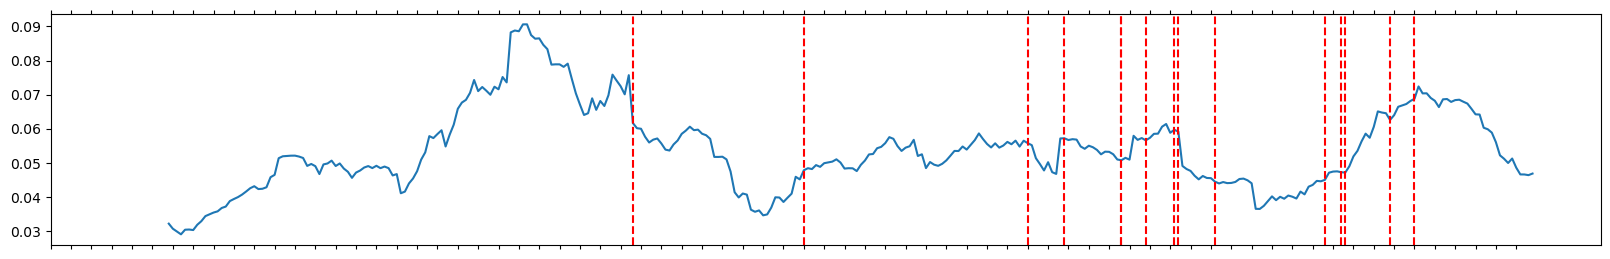

In [233]:
step_size = 5

xticks = np.arange(0, len(ts['ymd']), step_size)

plt.figure(figsize=(20,3))
plt.plot(pd.Series.rolling(ts['pred'], window = 30, center=False).mean())
plt.xticks(xticks, labels = md[xticks])
plt.tick_params(axis='x', length=3, pad=6, labelsize=4, labelcolor='green', top=True)


for _, row in event.iterrows():
    line_idx = ts[ts['ymd'] == str(row['date'])[5:-9]].index
    plt.axvline(line_idx, color = 'r', linestyle = '--')


In [190]:
data.to_csv("../../KakaoPay_ESG/result/KP_senti_ourB.csv")